# Investigating effect of using length-weight regressions for specimen weight proportions

This pertains to [Issue 429](https://github.com/OSOceanAcoustics/echopop/issues/429)

## Import necessary libraries and modules

In [ ]:
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import echopop.workflows.nwfsc_feat as feat
from echopop import inversion, utils
from echopop.geostatistics import cropping, kriging
from echopop.ingest import (
    join_geostrata_by_latitude,
    join_strata_by_haul,
    load_biological_data,
    load_geostrata,
    load_isobath_data,
    load_kriging_variogram_params,
    load_mesh_data,
    load_strata,
    nasc,
)
from echopop.survey import fit_length_weight_regression, proportions, transect
from echopop.workflows.nwfsc_feat import apportionment, biology

# ==================================================================================================
# ==================================================================================================
# DEFINE DATA ROOT DIRECTORY
# --------------------------
DATA_ROOT = Path("C:/Data/EchopopData/echopop_2019")

## Read in the acoustic dataand biological data

In [3]:
# ==================================================================================================
# ==================================================================================================
# DATA INGESTION
# ==================================================================================================
# Organize NASC file
# ------------------

# Merge exports
df_intervals, df_exports = nasc.merge_echoview_nasc(
    nasc_path=DATA_ROOT / "raw_nasc/",
    filename_transect_pattern=r"T(\d+)",
    default_transect_spacing=10.0,
    default_latitude_threshold=60.0,
)

# ==================================================================================================
# Read in transect-region-haul keys
# ---------------------------------
TRANSECT_REGION_FILEPATH_ALL_AGES = (
    DATA_ROOT / "Stratification/US_CAN_2019_transect_region_haul_age1+ auto_final.xlsx"
)
TRANSECT_REGION_FILEPATH_NO_AGE1 = (
    DATA_ROOT / "Stratification/US_CAN_2019_transect_region_haul_age2+ auto_20191205.xlsx"
)
TRANSECT_REGION_FILE_RENAME: dict = {
    "tranect": "transect_num",
    "region id": "region_id",
    "trawl #": "haul_num",
}
TRANSECT_REGION_SHEETNAME_ALL_AGES: str = "Sheet1"
TRANSECT_REGION_SHEETNAME_NO_AGE1: str = "Sheet1"

# Read in the transect-region-haul key files for each group
transect_region_haul_key_all_ages = nasc.read_transect_region_haul_key(
    filename=TRANSECT_REGION_FILEPATH_ALL_AGES,
    sheetname=TRANSECT_REGION_SHEETNAME_ALL_AGES,
    rename_dict=TRANSECT_REGION_FILE_RENAME,
)

transect_region_haul_key_no_age1: pd.DataFrame = nasc.read_transect_region_haul_key(
    TRANSECT_REGION_FILEPATH_NO_AGE1, TRANSECT_REGION_SHEETNAME_NO_AGE1, TRANSECT_REGION_FILE_RENAME
)

# ==================================================================================================
# Read in transect-region-haul keys
# ---------------------------------
REGION_NAME_EXPR_DICT: Dict[str, dict] = {
    "REGION_CLASS": {
        "Age-1 Hake": "^(?:h1a(?![a-z]|m))",
        "Age-1 Hake Mix": "^(?:h1am(?![a-z]|1a))",
        "Hake": "^(?:h(?![a-z]|1a)|hake(?![_]))",
        "Hake Mix": "^(?:hm(?![a-z]|1a)|hake_mix(?![_]))",
    },
    "HAUL_NUM": {
        "[0-9]+",
    },
    "COUNTRY": {
        "CAN": "^[cC]",
        "US": "^[uU]",
    },
}

# Process the region name codes to define the region classes
# e.g. H5C - Region 2 corresponds to "Hake, Haul #5, Canada"
df_exports_with_regions = nasc.process_region_names(
    df=df_exports,
    region_name_expr_dict=REGION_NAME_EXPR_DICT,
    can_haul_offset=200,
)

# ==================================================================================================
# Consolidate the Echvoiew NASC export files
# ------------------------------------------
df_nasc_no_age1 = nasc.consolidate_echvoiew_nasc(
    df_merged=df_exports_with_regions,
    interval_df=df_intervals,
    region_class_names=["Hake", "Hake Mix"],
    impute_region_ids=True,
    transect_region_haul_key_df=transect_region_haul_key_no_age1,
)


## Read in the biological data

In [4]:
# ==================================================================================================
# Load in the biolodical data
# ---------------------------
BIODATA_SHEETS = {
    "catch": "biodata_catch",
    "length": "biodata_length",
    "specimen": "biodata_specimen",
}
SUBSET_DICT = {
    "ships": {160: {"survey": 201906}, 584: {"survey": 2019097, "haul_offset": 200}},
    "species_code": [22500],
}
FEAT_TO_ECHOPOP_BIODATA_COLUMNS = {
    "frequency": "length_count",
    "haul": "haul_num",
    "weight_in_haul": "weight",
}
BIODATA_SEX = {"sex": {1: "male", 2: "female", 3: "unsexed"}}

#
dict_df_bio = load_biological_data(
    biodata_filepath=DATA_ROOT / "Biological/1995-2023_biodata_redo.xlsx",
    biodata_sheet_map=BIODATA_SHEETS,
    column_name_map=FEAT_TO_ECHOPOP_BIODATA_COLUMNS,
    subset_dict=SUBSET_DICT,
    biodata_label_map=BIODATA_SEX,
)

## Read in and apply stratification information

In [6]:
# ==================================================================================================
# Load in strata files
# --------------------
STRATA_SHEETS = {
    "inpfc": "INPFC",
    "ks": "Base KS",
}
FEAT_TO_ECHOPOP_STRATA_COLUMNS = {
    "fraction_hake": "nasc_proportion",
    "haul": "haul_num",
    "stratum": "stratum_num",
}

#
df_dict_strata = load_strata(
    strata_filepath=DATA_ROOT / "Stratification/US_CAN strata 2019_final.xlsx",
    strata_sheet_map=STRATA_SHEETS,
    column_name_map=FEAT_TO_ECHOPOP_STRATA_COLUMNS,
)

# ==================================================================================================
# Load in geographical strata files
# ---------------------------------
GEOSTRATA_SHEETS = {
    "inpfc": "INPFC",
    "ks": "stratification1",
}
FEAT_TO_ECHOPOP_GEOSTRATA_COLUMNS = {
    "latitude (upper limit)": "northlimit_latitude",
    "stratum": "stratum_num",
}

#
df_dict_geostrata = load_geostrata(
    geostrata_filepath=DATA_ROOT / "Stratification/Stratification_geographic_Lat_2019_final.xlsx",
    geostrata_sheet_map=GEOSTRATA_SHEETS,
    column_name_map=FEAT_TO_ECHOPOP_GEOSTRATA_COLUMNS,
)

# ==================================================================================================
# Stratify data based on haul numbers
# -----------------------------------
# Add KS
# ---- NASC
df_nasc_no_age1 = join_strata_by_haul(
    df_nasc_no_age1, df_dict_strata["ks"], stratum_name="stratum_ks"
)
# ---- Biodata
dict_df_bio = join_strata_by_haul(dict_df_bio, df_dict_strata["ks"], stratum_name="stratum_ks")

## Read in and pre-process geostats information

In [7]:
# ==================================================================================================
# Load kriging mesh file
# ----------------------

FEAT_TO_ECHOPOP_MESH_COLUMNS = {
    "centroid_latitude": "latitude",
    "centroid_longitude": "longitude",
    "fraction_cell_in_polygon": "fraction",
}

#
df_mesh = load_mesh_data(
    mesh_filepath=DATA_ROOT
    / "Kriging_files/Kriging_grid_files/krig_grid2_5nm_cut_centroids_2013.xlsx",
    sheet_name="krigedgrid2_5nm_forChu",
    column_name_map=FEAT_TO_ECHOPOP_MESH_COLUMNS,
)

# ==================================================================================================
# [OPTIONAL] Stratify data based on latitude intervals
# ----------------------------------------------------
# INPFC (from geostrata)
df_nasc_no_age1 = join_geostrata_by_latitude(
    df_nasc_no_age1, df_dict_geostrata["inpfc"], stratum_name="geostratum_inpfc"
)
# KS (from geostrata)
df_nasc_no_age1 = join_geostrata_by_latitude(
    df_nasc_no_age1, df_dict_geostrata["ks"], stratum_name="geostratum_ks"
)

# MESH
# ---- DataFrame merged with geographically distributed stratum number (KS or INPFC)
# -------- INPFC (from geostrata)
df_mesh = join_geostrata_by_latitude(
    df_mesh, df_dict_geostrata["inpfc"], stratum_name="geostratum_inpfc"
)
# -------- KS (from geostrata)
df_mesh = join_geostrata_by_latitude(df_mesh, df_dict_geostrata["ks"], stratum_name="geostratum_ks")

# ==================================================================================================
# Load kriging and variogram parameters
# -------------------------------------

FEAT_TO_ECHOPOP_GEOSTATS_PARAMS_COLUMNS = {
    "hole": "hole_effect_range",
    "lscl": "correlation_range",
    "nugt": "nugget",
    "powr": "decay_power",
    "ratio": "aspect_ratio",
    "res": "lag_resolution",
    "srad": "search_radius",
}

#
dict_kriging_params, dict_variogram_params = load_kriging_variogram_params(
    geostatistic_params_filepath=(
        DATA_ROOT / "Kriging_files/default_vario_krig_settings_2019_US_CAN.xlsx"
    ),
    sheet_name="Sheet1",
    column_name_map=FEAT_TO_ECHOPOP_GEOSTATS_PARAMS_COLUMNS,
)

## Begin processing biological data

In [8]:
# ==================================================================================================
# ==================================================================================================
# DATA PROCESSING
# ==================================================================================================
# Generate binned distributions [age, length]
# -------------------------------------------
AGE_BINS = np.linspace(start=1.0, stop=22.0, num=22)
LENGTH_BINS = np.linspace(start=2.0, stop=80.0, num=40)

#
# ---- Length
utils.binify(
    data=dict_df_bio,
    bins=LENGTH_BINS,
    bin_column="length",
)

# Age
utils.binify(
    data=dict_df_bio,
    bins=AGE_BINS,
    bin_column="age",
)

# ==================================================================================================
# Fit length-weight regression to the binned data
# -----------------------------------------------

# Dictionary for length-weight regression coefficients
dict_length_weight_coefs = {}

# For all fish
dict_length_weight_coefs["all"] = (
    dict_df_bio["specimen"]
    .assign(sex="all")
    .groupby(["sex"])
    .apply(fit_length_weight_regression, include_groups=False)
)

# Sex-specific
dict_length_weight_coefs["sex"] = (
    dict_df_bio["specimen"]
    .groupby(["sex"])
    .apply(fit_length_weight_regression, include_groups=False)
)

# ==================================================================================================
# Compute the mean weights per length bin
# ---------------------------------------

# Sex-specific (grouped coefficients)
da_binned_weights_sex = biology.length_binned_weights(
    data=dict_df_bio["specimen"],
    length_bins=LENGTH_BINS,
    regression_coefficients=dict_length_weight_coefs["sex"],
    impute_bins=True,
    minimum_count_threshold=5,
)

# All fish (single coefficient set)
da_binned_weights_all = biology.length_binned_weights(
    data=dict_df_bio["specimen"].assign(sex="all"),
    length_bins=LENGTH_BINS,
    regression_coefficients=dict_length_weight_coefs["all"],
    impute_bins=True,
    minimum_count_threshold=5,
)

# Combine the pivot tables by adding the "all" column to the sex-specific table
da_binned_weight_table = xr.concat(
    [da_binned_weights_sex, da_binned_weights_all],
    dim = "sex"
)
# ==================================================================================================
# Compute the count distributions per age- and length-bins
# --------------------------------------------------------

# DATASET CONTAINER
ds_counts = xr.Dataset()

# AGED
ds_counts["aged"] = proportions.compute_binned_counts(
    data=dict_df_bio["specimen"].dropna(subset=["age", "length", "weight"]),
    groupby_cols=["stratum_ks", "length_bin", "age_bin", "sex"],
    count_col="length",
    agg_func="size",
)

# UNAGED
ds_counts["unaged"] = proportions.compute_binned_counts(
    data=dict_df_bio["length"].copy().dropna(subset=["length"]),
    groupby_cols=["stratum_ks", "length_bin", "sex"],
    count_col="length_count",
    agg_func="sum",
)

# ==================================================================================================
# Compute the number proportions
# ------------------------------
dict_ds_number_proportion = proportions.number_proportions(
    data=ds_counts,
    group_columns=["stratum_ks"],
    exclude_filters={"aged": {"sex": "unsexed"}},
)

## Binned weights

We now begin the parallel calculations for the binned weights (and subsequent weight proportions) using the current implementation where empirical specimen weights (denoted `*_empirical`) are used versus using the length-weight regression (denoted `*_regression`).

In [10]:
# ==================================================================================================
# Distribute (bin) weight over age, length, and sex
# -------------------------------------------------
# Pre-allocate a dataset
weight_bins_empirical = xr.Dataset()
weight_bins_regression = xr.Dataset()

# Aged
weight_bins_empirical["aged"] = proportions.binned_weights(
    length_data=dict_df_bio["specimen"],
    include_filter={"sex": ["female", "male"]},
    interpolate_regression=False,
    group_columns=["stratum_ks", "sex", "age_bin"],
)

weight_bins_regression["aged"] = proportions.binned_weights(
    length_data=dict_df_bio["specimen"],
    include_filter={"sex": ["female", "male"]},
    interpolate_regression=True,
    length_weight_data=da_binned_weight_table,
    group_columns=["stratum_ks", "sex", "age_bin"],
)

# Unaged
weight_bins_empirical["unaged"] = proportions.binned_weights(
    length_data=dict_df_bio["length"],
    include_filter={"sex": ["female", "male"]},
    interpolate_regression=True,
    length_weight_data=da_binned_weight_table,
    group_columns=["stratum_ks", "sex"],
)

weight_bins_regression["unaged"] = proportions.binned_weights(
    length_data=dict_df_bio["length"],
    include_filter={"sex": ["female", "male"]},
    interpolate_regression=True,
    length_weight_data=da_binned_weight_table,
    group_columns=["stratum_ks", "sex"],
)

### Comparing over different data layers

Differences in the age-length distributions of binned weights can be visualized for each stratum.

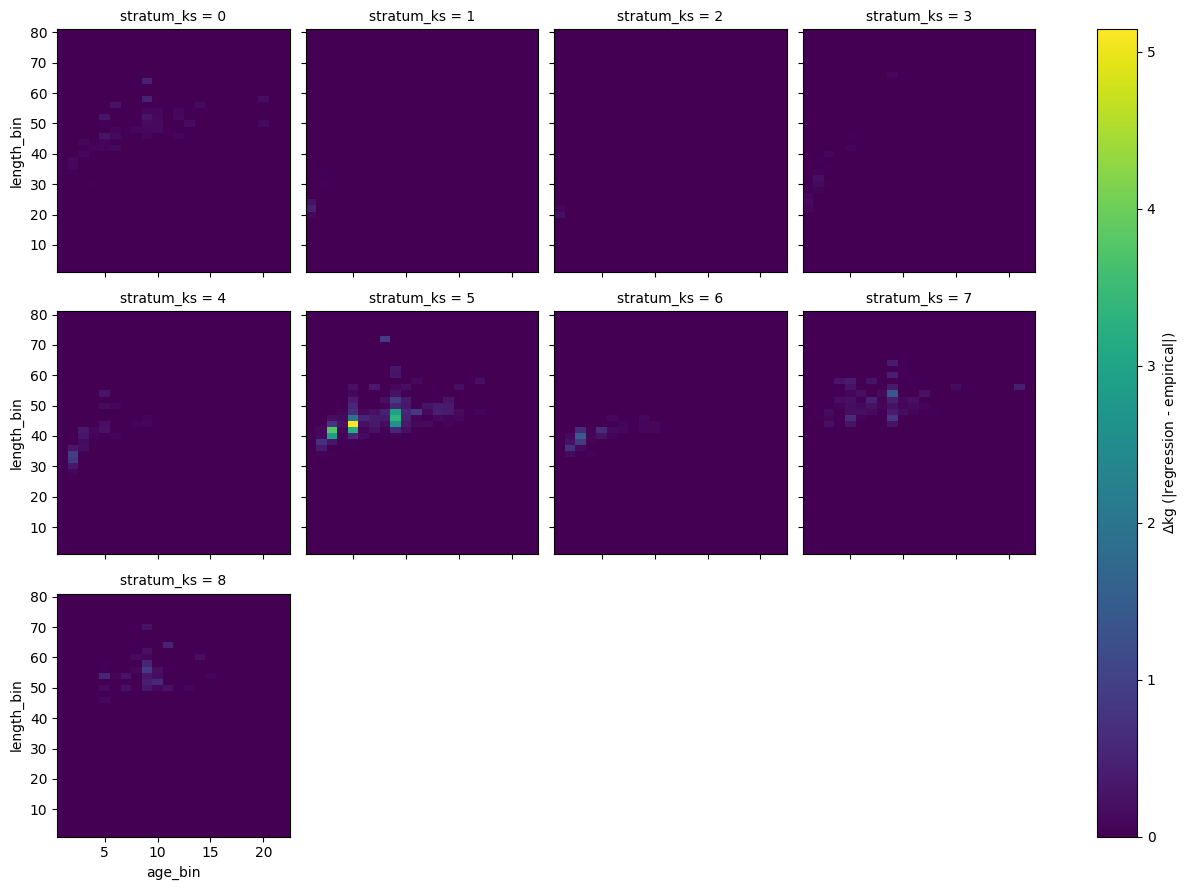

In [42]:
DELTA_WEIGHT_BINS = np.abs(weight_bins_regression["aged"].sum(dim="sex") - weight_bins_empirical["aged"].sum(dim="sex"))

DELTA_WEIGHT_BINS.astype(float).plot(
    x="age_bin", 
    y="length_bin", 
    col="stratum_ks", 
    col_wrap=4, 
    cmap="viridis", 
    cbar_kwargs={"label": r"$\Delta$kg (|regression - empirical|)"}
)

We can also look at the summed differences across each stratum.

In [54]:
DELTA_STRATUM_WEIGHT_BINS = (
    np.abs(
        weight_bins_regression["aged"].sum(dim=["length_bin", "age_bin"]) - 
        weight_bins_empirical["aged"].sum(dim=["length_bin", "age_bin"])
    )
)
DELTA_STRATUM_WEIGHT_BINS.astype(float)

<xarray.DataArray 'aged' (stratum_ks: 9, sex: 2)> Size: 144B
array([[ 1.22622107,  1.12275663],
       [ 0.52181684,  0.39169257],
       [ 0.13734963,  0.17133471],
       [ 0.8446336 ,  0.33170637],
       [ 2.89924509,  1.91604069],
       [24.92234202, 19.34999682],
       [ 2.72310495,  3.43839112],
       [ 2.71312955,  0.40146599],
       [ 4.22807533,  1.95001896]])
Coordinates:
  * stratum_ks  (stratum_ks) int64 72B 0 1 2 3 4 5 6 7 8
  * sex         (sex) object 16B 'female' 'male'

## Weight proportions


We now do the same parallel calculation for weight proportions.

In [69]:
# ==================================================================================================
# Compute the length-binned weight proportions for aged fish
# ----------------------------------------------------------

# Initialize Dictionary container
weight_proportions_empirical = {}
weight_proportions_regression = {}

# Aged
weight_proportions_empirical["aged"] = proportions.weight_proportions(
    weight_data=weight_bins_empirical["aged"], 
    catch_data=dict_df_bio["catch"], 
    group_columns = ["stratum_ks"]
)
weight_proportions_regression["aged"] = proportions.weight_proportions(
    weight_data=weight_bins_regression["aged"].astype(float),
    catch_data=dict_df_bio["catch"], 
    group_columns = ["stratum_ks"]
).astype(float)

# ==================================================================================================
# Compute the standardized weight proportionsfor unaged fish
# ----------------------------------------------------------
weight_proportions_empirical["unaged"] = proportions.fitted_weight_proportions(
    weight_data=weight_bins_empirical["unaged"],
    reference_weight_proportions=weight_proportions_empirical["aged"],
    catch_data=dict_df_bio["catch"],
    number_proportions=dict_ds_number_proportion["unaged"],
    binned_weights=da_binned_weights_all,
    stratum_dim=["stratum_ks"]
)
weight_proportions_regression["unaged"] = proportions.fitted_weight_proportions(
    weight_data=weight_bins_regression["unaged"],
    reference_weight_proportions=weight_proportions_regression["aged"],
    catch_data=dict_df_bio["catch"],
    number_proportions=dict_ds_number_proportion["unaged"],
    binned_weights=da_binned_weights_all,
    stratum_dim=["stratum_ks"]
)

### Comparing over different data layers

The differences in weight proportions can be visualized for each stratum.

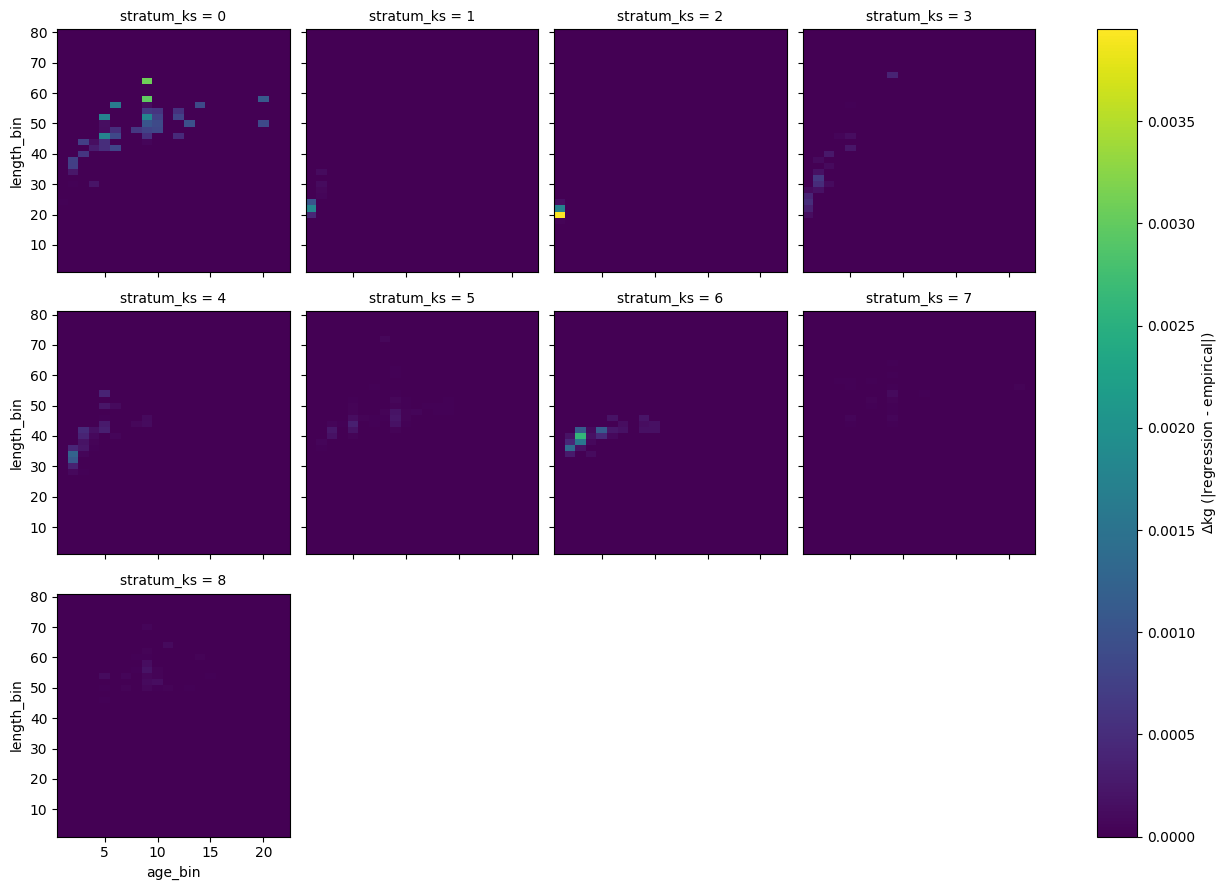

In [72]:
DELTA_WEIGHT_PROPS = np.abs(
    weight_proportions_regression["aged"].sum(dim="sex") - 
    weight_proportions_empirical["aged"].sum(dim="sex")
)

DELTA_WEIGHT_PROPS["proportion_overall"].plot(
    x="age_bin", 
    y="length_bin", 
    col="stratum_ks", 
    col_wrap=4, 
    cmap="viridis", 
    cbar_kwargs={"label": r"$\Delta$kg (|regression - empirical|)"}
)

The differences can also be aggregated to look at the differences in cumulative/summed proportions across strata.

In [74]:
DELTA_STRATUM_WEIGHT_PROPORTIONS = (
    np.abs(
        weight_proportions_regression["aged"].sum(dim=["length_bin", "age_bin"]) - 
        weight_proportions_empirical["aged"].sum(dim=["length_bin", "age_bin"])
    )
)
DELTA_STRATUM_WEIGHT_PROPORTIONS["proportion_overall"].astype(float)

<xarray.DataArray 'proportion_overall' (stratum_ks: 9, sex: 2)> Size: 144B
array([[8.00158052e-03, 7.65203668e-03],
       [2.08627272e-03, 1.53924736e-03],
       [2.64142908e-03, 3.24350422e-03],
       [3.13881853e-03, 1.19025375e-03],
       [3.88736130e-03, 2.55273213e-03],
       [1.63403279e-03, 1.23710735e-03],
       [4.94328277e-03, 6.21849745e-03],
       [1.95197962e-04, 2.84755938e-05],
       [9.46555326e-04, 4.38123934e-04]])
Coordinates:
  * stratum_ks  (stratum_ks) int64 72B 0 1 2 3 4 5 6 7 8
  * sex         (sex) object 16B 'female' 'male'

## Inversion

In [ ]:
# ==================================================================================================
# Calculate the average weights pre stratum when combining different datasets
# ---------------------------------------------------------------------------
da_averaged_weight = proportions.stratum_averaged_weight(
    number_proportions=dict_ds_number_proportion,
    length_weight_data=da_binned_weight_table,
    group_columns=["stratum_ks"]
)

# ==================================================================================================
# ==================================================================================================
# NASC TO POPULATION ESTIMATE CONVERSION
# ==================================================================================================
# Initialize the Inversion class
# ------------------------------
MODEL_PARAMETERS = {
    "ts_length_regression": {"slope": 20.0, "intercept": -68.0},
    "stratify_by": ["stratum_ks"],
    "expected_strata": df_dict_strata["ks"].stratum_num.unique(),
    "impute_missing_strata": True,
    "haul_replicates": True,
}

# Initiate object to perform inversion
invert_hake = inversion.InversionLengthTS(MODEL_PARAMETERS)

# ==================================================================================================
# Invert number density
# ---------------------

# If the above haul-averaged `sigma_bs` values were calculated, then the inversion can can
# completed without calling in additional biodata
df_nasc_no_age1 = invert_hake.invert(
    df_nasc=df_nasc_no_age1, df_length=[dict_df_bio["length"], dict_df_bio["specimen"]]
)

# ==================================================================================================
# Set transect interval distances
# -------------------------------

# Calculate along-transect interval distances which is required for getting the area-per-interval
# and therefore going from number density to abundance
transect.compute_interval_distance(df_nasc=df_nasc_no_age1, interval_threshold=0.05)

# ==================================================================================================
# Calculate transect interval areas
# ---------------------------------
df_nasc_no_age1["area_interval"] = (
    df_nasc_no_age1["transect_spacing"] * df_nasc_no_age1["distance_interval"]
)

# ==================================================================================================
# Calculate (and apportion) number densities to abundance, and number densities/abundance for each
# sex
# --------------------------------------------------------------------------------------------------

biology.compute_abundance(
    transect_data=df_nasc_no_age1,
    exclude_filter={"sex": "unsexed"},
    number_proportions=dict_ds_number_proportion,
)

# ==================================================================================================
# Calculate (and apportion) biomass densities and biomass (from number density and abundance,
# respectively) for the overall transect dataset as well as for each sex
# --------------------------------------------------------------------------------------------------

biology.compute_biomass(
    transect_data=df_nasc_no_age1,
    stratum_weights=da_averaged_weight,
)

## Compute age-1 proportion slices

In [178]:
# ==================================================================================================
# Get proportions for each stratum specific to age-1
# --------------------------------------------------
# Age-1 NASC proportions
da_age1_nasc_proportions = proportions.get_nasc_proportions_slice(
    number_proportions=dict_ds_number_proportion["aged"],
    group_columns=["stratum_ks"],
    ts_length_regression_parameters={"slope": 20.0, "intercept": -68.0},
    include_filter={"age_bin": [1]},
)

# Age-1 number proportions
da_age1_number_proportions = proportions.get_number_proportions_slice(
    number_proportions=dict_ds_number_proportion["aged"],
    stratum_dim=["stratum_ks"],
    include_filter={"age_bin": [1]},
)

# Age-1 weight proportions
age1_weight_proportions_empirical = proportions.get_weight_proportions_slice(
    weight_proportions=weight_proportions_empirical["aged"],
    stratum_dim=["stratum_ks"],
    include_filter={"age_bin": [1]},
    number_proportions=dict_ds_number_proportion,
    length_threshold_min=10.0,
    weight_proportion_threshold=1e-10,
)

age1_weight_proportions_regression = proportions.get_weight_proportions_slice(
    weight_proportions=weight_proportions_regression["aged"],
    stratum_dim=["stratum_ks"],
    include_filter={"age_bin": [1]},
    number_proportions=dict_ds_number_proportion,
    length_threshold_min=10.0,
    weight_proportion_threshold=1e-10,
)

We can see how the differences in weight proportions propagate into differences for the age-1 contributions.

In [179]:
age1_weight_proportions_empirical - age1_weight_proportions_regression

<xarray.DataArray 'proportion_overall' (stratum_ks: 9)> Size: 72B
array([0.00000000e+00, 1.00842657e-03, 0.00000000e+00, 4.39613991e-03,
       0.00000000e+00, 9.59429871e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])
Coordinates:
  * stratum_ks  (stratum_ks) int64 72B 0 1 2 3 4 5 6 7 8

## Partition NASC by removing age-1

In [180]:
# ==================================================================================================
# Apply the calculated proportions to the abundance, biomass, and NASC estimates
# ------------------------------------------------------------------------------

df_nasc_noage1_empirical = apportionment.remove_group_from_estimates(
    transect_data=df_nasc_no_age1,
    group_proportions=xr.Dataset({
        "nasc": da_age1_nasc_proportions,
        "abundance": da_age1_number_proportions,
        "biomass": age1_weight_proportions_empirical,
    }),
)

df_nasc_noage1_regression = apportionment.remove_group_from_estimates(
    transect_data=df_nasc_no_age1,
    group_proportions=xr.Dataset({
        "nasc": da_age1_nasc_proportions,
        "abundance": da_age1_number_proportions,
        "biomass": age1_weight_proportions_regression,
    }),
)


We can then sum the total biomass to see the total difference, which in this case is approximately 89,700 kg, which is ~ 0.01% change in the total biomass estimate.

In [181]:
df_nasc_noage1_regression["biomass"].sum() - df_nasc_noage1_empirical["biomass"].sum()

np.float64(89748.19574904442)

## Distribute across tables

Just as before, we do a parallel workflow for the empirical and regressed weights. Here, abundance and biomass from the transect estimates are distributed over age and length for the aged data. The differences in the age-length distributions are visualized, as well as the sums for each stratum.

### Abundance

In [182]:
# ==================================================================================================
# Distribute transect abundances across age-length-sex bins
# ---------------------------------------------------------

transect_abundance_table_empirical = apportionment.distribute_population_estimates(
    data=df_nasc_noage1_empirical,
    proportions = dict_ds_number_proportion,
    variable = "abundance",
    group_columns= ["sex", "age_bin", "length_bin", "stratum_ks"]
)

transect_abundance_table_regression = apportionment.distribute_population_estimates(
    data=df_nasc_noage1_regression,
    proportions = dict_ds_number_proportion,
    variable = "abundance",
    group_columns= ["sex", "age_bin", "length_bin", "stratum_ks"]
)

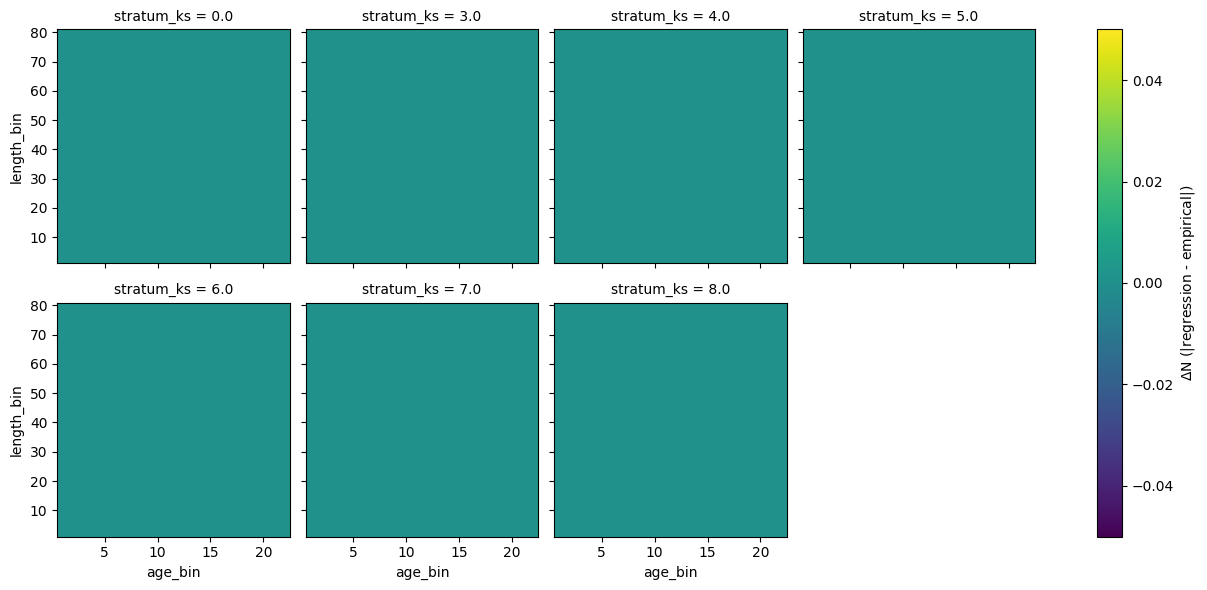

In [183]:
DELTA_ABUNDANCE_TABLE = np.abs(
    transect_abundance_table_regression["aged"].sum(dim="sex") - 
    transect_abundance_table_empirical["aged"].sum(dim="sex")
)

DELTA_ABUNDANCE_TABLE.plot(
    x="age_bin", 
    y="length_bin", 
    col="stratum_ks", 
    col_wrap=4, 
    cmap="viridis", 
    cbar_kwargs={"label": r"$\Delta$N (|regression - empirical|)"}
)

As shown here, the abundance estimates are ultimately agnostic to any changes in how the specimen weight proportions are computed.

### Biomass

In [ ]:
# ==================================================================================================
# Distribute transect biomasses across age-length-sex bins
# ---------------------------------------------------------

transect_biomass_table_empirical = apportionment.distribute_population_estimates(
    data=df_nasc_noage1_empirical,
    proportions = weight_proportions_empirical,
    variable="biomass",
    group_columns= ["sex", "age_bin", "length_bin", "stratum_ks"]
)

transect_biomass_table_regression = apportionment.distribute_population_estimates(
    data=df_nasc_noage1_regression,
    proportions = weight_proportions_regression,
    variable="biomass",
    group_columns= ["sex", "age_bin", "length_bin", "stratum_ks"]
)

In [188]:
transect_biomass_table_empirical["aged"].sum() + transect_biomass_table_empirical["unaged"].sum()

<xarray.DataArray 'biomass' ()> Size: 8B
array(1.63620198e+09)

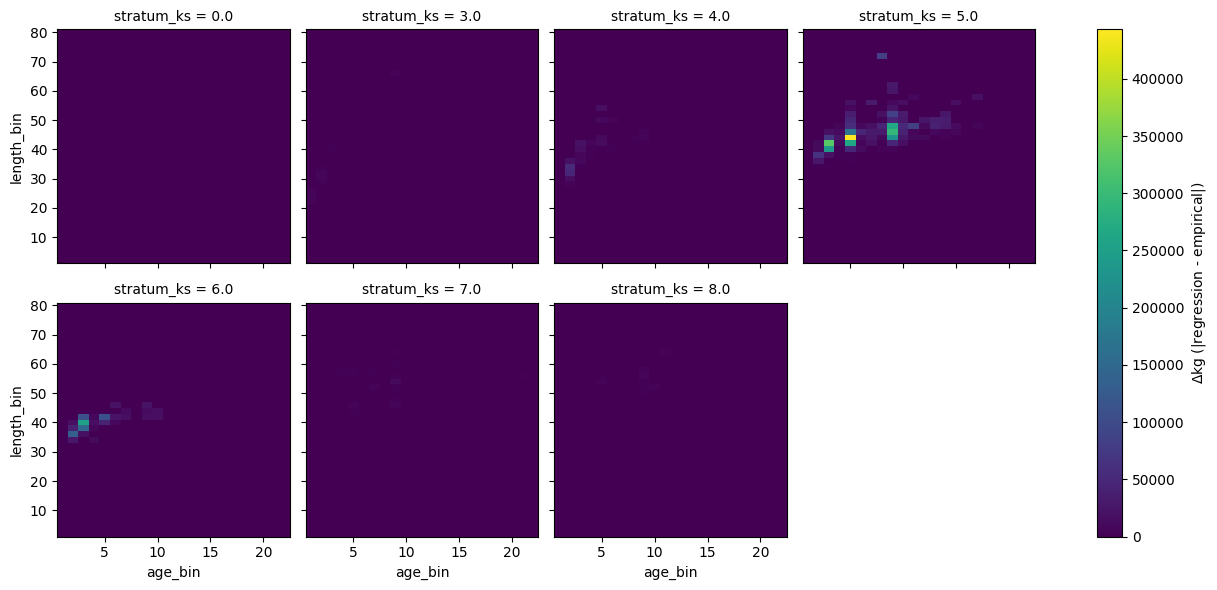

In [185]:
DELTA_BIOMASS_TABLE = np.abs(
    transect_biomass_table_regression["aged"].sum(dim="sex") - 
    transect_biomass_table_empirical["aged"].sum(dim="sex")
)

DELTA_BIOMASS_TABLE.plot(
    x="age_bin", 
    y="length_bin", 
    col="stratum_ks", 
    col_wrap=4, 
    cmap="viridis", 
    cbar_kwargs={"label": r"$\Delta$kg (|regression - empirical|)"}
)

In [88]:
DELTA_STRATUM_BIOMASS = (
    np.abs(
        transect_biomass_table_regression["aged"].sum(dim=["length_bin", "age_bin"]) - 
        transect_biomass_table_empirical["aged"].sum(dim=["length_bin", "age_bin"])
    )
)
DELTA_STRATUM_BIOMASS

<xarray.DataArray 'biomass' (stratum_ks: 7, sex: 2)> Size: 112B
array([[      0.        ,       0.        ],
       [  35463.10625958,   14193.29729001],
       [ 165657.06887979,  108782.81938555],
       [2203252.4614455 , 1668197.71160118],
       [ 482499.05824336,  606968.95190227],
       [  20217.38584059,    2949.32417478],
       [  32586.10445293,   15082.85027564]])
Coordinates:
  * stratum_ks  (stratum_ks) float64 56B 0.0 3.0 4.0 5.0 6.0 7.0 8.0
  * sex         (sex) object 16B 'female' 'male'

Unlike abundance, the biomass estimates are directly impacted by changes in the weight proportions. This results in relatively non-trivial changes to the biomass estimates of the aged estimates.

In [199]:
DELTA_STRATUM_BIOMASS / (
    (
        transect_biomass_table_regression["aged"].sum(dim=["length_bin", "age_bin"]) + 
        transect_biomass_table_empirical["aged"].sum(dim=["length_bin", "age_bin"])
    )/2
) * 1e2

<xarray.DataArray 'biomass' (stratum_ks: 7, sex: 2)> Size: 112B
array([[        nan,         nan],
       [ 6.61984754,  4.73010354],
       [ 9.98245634,  9.08395931],
       [ 4.14265623,  3.03701139],
       [ 9.01805481,  8.75413692],
       [ 2.16222127,  0.90732862],
       [ 9.20494047, 12.07750235]])
Coordinates:
  * stratum_ks  (stratum_ks) float64 56B 0.0 3.0 4.0 5.0 6.0 7.0 8.0
  * sex         (sex) object 16B 'female' 'male'

But when combined with the unaged estimates, these differences substantially dissipate, indicating that most of the deviation is accounted for by the weight proportions that are shifted to the unaged dataset.

In [198]:
# Get stratified sums
stratified_empirical = (
    transect_biomass_table_empirical["aged"].sum(dim=["sex", "length_bin", "age_bin"]) +
    transect_biomass_table_empirical["unaged"].sum(dim=["sex", "length_bin"])
)
stratified_regression = (
    transect_biomass_table_regression["aged"].sum(dim=["sex", "length_bin", "age_bin"]) +
    transect_biomass_table_regression["unaged"].sum(dim=["sex", "length_bin"])
)
np.abs(
    stratified_empirical - stratified_regression
) / ((stratified_empirical + stratified_regression)/2) * 1e2


<xarray.DataArray 'biomass' (stratum_ks: 7)> Size: 56B
array([           nan, 7.69223903e-01, 0.00000000e+00, 9.59697159e-04,
       1.52664865e-14, 1.43870049e-14, 0.00000000e+00])
Coordinates:
  * stratum_ks  (stratum_ks) float64 56B 0.0 3.0 4.0 5.0 6.0 7.0 8.0

## Geostatistics

In [95]:
# ==================================================================================================
# ==================================================================================================
# GEOSTATISTICS
# ==================================================================================================
# Load reference line (isobath)
# -----------------------------

df_isobath = load_isobath_data(
    isobath_filepath=DATA_ROOT
    / "Kriging_files/Kriging_grid_files/transformation_isobath_coordinates.xlsx",
    sheet_name="Smoothing_EasyKrig",
)

# ==================================================================================================
# Transform the geospatial coordinates for the transect data
# ----------------------------------------------------------
df_nasc_no_age1_empirical, delta_longitude, delta_latitude = cropping.transform_coordinates(
    data=df_nasc_noage1_empirical,
    reference=df_isobath,
    x_offset=-124.78338,
    y_offset=45.0,
)

df_nasc_no_age1_regression, delta_longitude, delta_latitude = cropping.transform_coordinates(
    data=df_nasc_noage1_regression,
    reference=df_isobath,
    x_offset=-124.78338,
    y_offset=45.0,
)

# ==================================================================================================
# Transform the geospatial coordinates for the mesh data
# ------------------------------------------------------
df_mesh, _, _ = cropping.transform_coordinates(
    data=df_mesh,
    reference=df_isobath,
    x_offset=-124.78338,
    y_offset=45.0,
    delta_x=delta_longitude,
    delta_y=delta_latitude,
)

# ==================================================================================================
# Initialize the kriging class object
# -----------------------------------

# Define the requisite kriging parameters
KRIGING_PARAMETERS = {
    "search_radius": 0.021,
    "aspect_ratio": 0.001,
    "k_min": 3,
    "k_max": 10,
}

# Define the requisite variogram parameters and arguments
VARIOGRAM_PARAMETERS = {
    "model": ["exponential", "bessel"], 
    "nugget": 0.0,
    "sill": 0.91,
    "correlation_range": 0.007,
    "decay_power": 1.5,
    "hole_effect_range": 0.0
    
    }

krg_empirical = kriging.Kriging(
    mesh=df_mesh,
    kriging_params=KRIGING_PARAMETERS,
    variogram_params=VARIOGRAM_PARAMETERS,
    coordinate_names=("x", "y"),
)

krg_regression = kriging.Kriging(
    mesh=df_mesh,
    kriging_params=KRIGING_PARAMETERS,
    variogram_params=VARIOGRAM_PARAMETERS,
    coordinate_names=("x", "y"),
)

# ==================================================================================================
# Mesh cropping using the hull convex
# -----------------------------------

krg_empirical.crop_mesh(
    crop_function=feat.transect_ends_crop,
    transects=df_nasc_noage1_empirical,
    latitude_resolution=1.25 / 60.0,
    transect_mesh_region_function=feat.parameters.transect_mesh_region_2019,
)

krg_regression.crop_mesh(
    crop_function=feat.transect_ends_crop,
    transects=df_nasc_noage1_regression,
    latitude_resolution=1.25 / 60.0,
    transect_mesh_region_function=feat.parameters.transect_mesh_region_2019,
)

# ==================================================================================================
# [FEAT] Get the western extent of the transect bounds
# ----------------------------------------------------
transect_western_extents_empirical = feat.get_survey_western_extents(
    transects=df_nasc_noage1_empirical, coordinate_names=("x", "y"), latitude_threshold=51.0
)

transect_western_extents_regression = feat.get_survey_western_extents(
    transects=df_nasc_noage1_regression, coordinate_names=("x", "y"), latitude_threshold=51.0
)

# ==================================================================================================
# [FEAT] Register the custom search strategy
# ------------------------------------------
krg_empirical.register_search_strategy("FEAT_strategy", feat.western_boundary_search_strategy)
krg_regression.register_search_strategy("FEAT_strategy", feat.western_boundary_search_strategy)
# ---- Verify that method was registered
krg_empirical.list_search_strategies()
krg_regression.list_search_strategies()
# ==================================================================================================
# Krige the biomass density to get kriged biomass
# -----------------------------------------------

# Define the required keyword arguments for 'FEAT_strategy'
# ---- Only `transect_western_extents` is needed for this particular function since the
# `kriging_mesh` and `coordinate_names` arguments are inherited from the class instance
FEAT_STRATEGY_KWARGS_EMPIRICAL = {
    "western_extent": transect_western_extents_empirical,
}
FEAT_STRATEGY_KWARGS_REGRESSION = {
    "western_extent": transect_western_extents_regression,
}

# Krige
kriged_results_empirical = krg_empirical.krige(
    transects=df_nasc_noage1_empirical,
    variable="biomass_density",
    extrapolate=False,
    default_mesh_cell_area=6.25,
    adaptive_search_strategy="FEAT_strategy",
    custom_search_kwargs=FEAT_STRATEGY_KWARGS_EMPIRICAL,
)

kriged_results_regression = krg_regression.krige(
    transects=df_nasc_noage1_regression,
    variable="biomass_density",
    extrapolate=False,
    default_mesh_cell_area=6.25,
    adaptive_search_strategy="FEAT_strategy",
    custom_search_kwargs=FEAT_STRATEGY_KWARGS_REGRESSION,
)


C:\Users\Brandyn\GitHub\echopop\echopop\geostatistics\kriging.py:1451: UserWarning: 352 invalid kriged estimates (< 0.0) found. These have been replaced with '0.0'; however, this truncation may distort error distributions. If this is problematic, adjust the choice of variogram and kriging algorithm parameterization.
  kriged_results, _ = project_kriging_results(
C:\Users\Brandyn\GitHub\echopop\echopop\geostatistics\kriging.py:1451: UserWarning: 352 invalid kriged estimates (< 0.0) found. These have been replaced with '0.0'; however, this truncation may distort error distributions. If this is problematic, adjust the choice of variogram and kriging algorithm parameterization.
  kriged_results, _ = project_kriging_results(


## Compute abundance, biomass, and NASC from kriged biomass densities

In [96]:
# ##################################################################################################
# Back-calculate sex-specific biomass and abundance, and total NASC from the kriged biomass
# density estimates
# -----------------

# Compute biomass
kriged_results_empirical["biomass"] = kriged_results_empirical["biomass_density"] * kriged_results_empirical["area"]
kriged_results_regression["biomass"] = kriged_results_regression["biomass_density"] * kriged_results_regression["area"]

# Convert biomass to abundance to NASC
apportionment.mesh_biomass_to_nasc(
    mesh_data=kriged_results_empirical,
    biodata=weight_proportions_empirical,
    group_columns=["sex", "stratum_ks"],
    mesh_biodata_link={"geostratum_ks": "stratum_ks"},
    stratum_weights=da_averaged_weight.sel(sex="all"),
    stratum_sigma_bs=invert_hake.sigma_bs_strata,
)
apportionment.mesh_biomass_to_nasc(
    mesh_data=kriged_results_regression,
    biodata=weight_proportions_regression,
    group_columns=["sex", "stratum_ks"],
    mesh_biodata_link={"geostratum_ks": "stratum_ks"},
    stratum_weights=da_averaged_weight.sel(sex="all"),
    stratum_sigma_bs=invert_hake.sigma_bs_strata,
)

### Compare geographically

We can see how these values change over geographic regions.

In [200]:
# Set indices
kriged_results_regression.set_index(["longitude", "latitude"], inplace=True)
kriged_results_empirical.set_index(["longitude", "latitude"], inplace=True)

# Get differences
DELTA_BIOMASS = np.abs(
    kriged_results_regression["biomass"] - kriged_results_empirical["biomass"]
) / ((kriged_results_regression["biomass"] + kriged_results_empirical["biomass"])/2) * 1e2
DELTA_BIODENS = np.abs(
    kriged_results_regression["biomass_density"] - kriged_results_empirical["biomass_density"]
) / ((kriged_results_regression["biomass_density"] + kriged_results_empirical["biomass_density"])/2) * 1e2
DELTA_ABUNDANCE = np.abs(
    kriged_results_regression["abundance"] - kriged_results_empirical["abundance"]
) / ((kriged_results_regression["abundance"] + kriged_results_empirical["abundance"])/2) * 1e2
DELTA_NASC = np.abs(
    kriged_results_regression["nasc"] - kriged_results_empirical["nasc"]
)/ ((kriged_results_regression["nasc"] + kriged_results_empirical["nasc"])/2) * 1e2

# Reset indices
kriged_results_regression.reset_index(inplace=True)
kriged_results_empirical.reset_index(inplace=True)

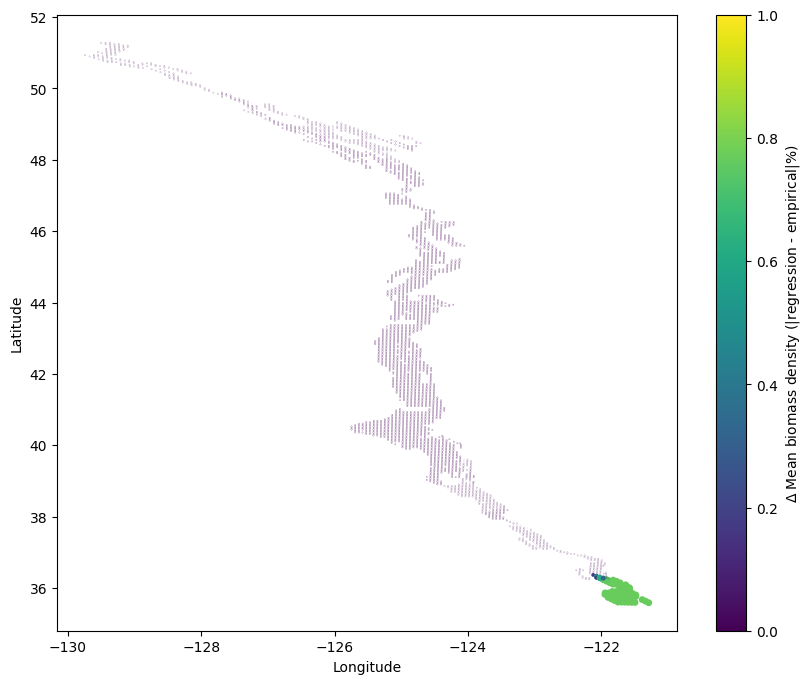

In [206]:

# Reset index to turn longitude/latitude into columns
df_plot = DELTA_BIODENS.reset_index()
pt_size = np.where(
    df_plot["biomass_density"] > 0, 
    df_plot["biomass_density"] * 20,
    0.01
)

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    x=df_plot["longitude"], 
    y=df_plot["latitude"], 
    c=df_plot["biomass_density"], # The color values
    cmap="viridis",
    s=pt_size, # Size of the points,
    vmin = 0,
    vmax = 1.0
)
plt.colorbar(sc, label=r"$\Delta$ Mean biomass density (|regression - empirical|%)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

And by strata.

In [207]:
(
    kriged_results_regression.groupby(["geostratum_ks"], observed=False)["biomass_density"].mean() - 
    kriged_results_empirical.groupby(["geostratum_ks"], observed=False)["biomass_density"].mean()
)

geostratum_ks
1     0.079105
2     0.000000
3    49.694142
4     1.351115
5     0.459641
6     0.075865
7     0.133065
8     0.149748
Name: biomass_density, dtype: float64

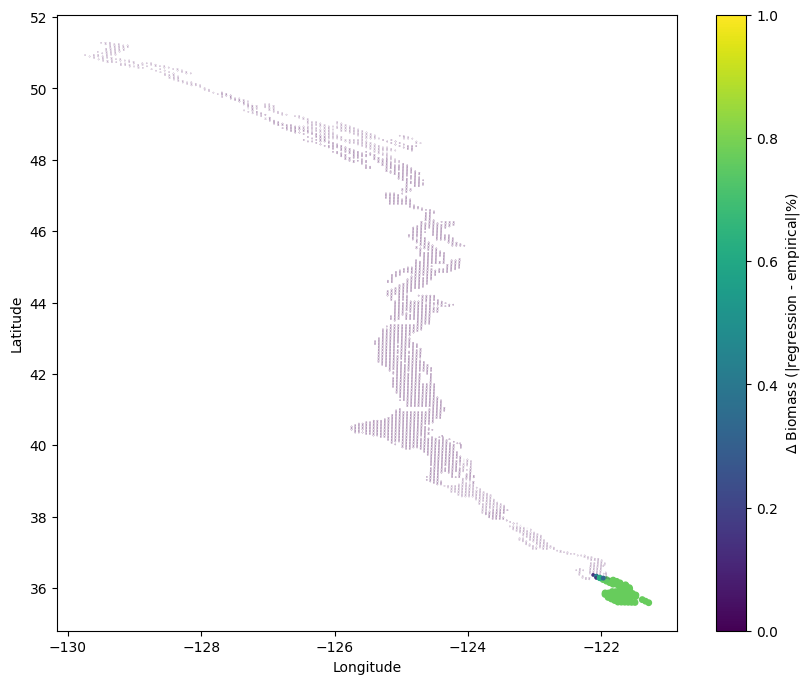

In [208]:
# Reset index to turn longitude/latitude into columns
df_plot = DELTA_BIOMASS.reset_index()
pt_size = np.where(
    df_plot["biomass"] > 0, 
    df_plot["biomass"] * 20,
    0.01
)

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    x=df_plot["longitude"], 
    y=df_plot["latitude"], 
    c=df_plot["biomass"], # The color values
    cmap="viridis",
    s=pt_size, # Size of the points,
    vmin = 0,
    vmax = 1.0
)
plt.colorbar(sc, label=r"$\Delta$ Biomass (|regression - empirical|%)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [172]:
(
    kriged_results_regression.groupby(["geostratum_ks"], observed=False)["biomass"].sum() - 
    kriged_results_empirical.groupby(["geostratum_ks"], observed=False)["biomass"].sum()
)

geostratum_ks
1     1558.865266
2        0.000000
3    68167.334642
4     4627.569051
5    12053.685513
6      136.556111
7      486.517948
8      219.006644
Name: biomass, dtype: float64

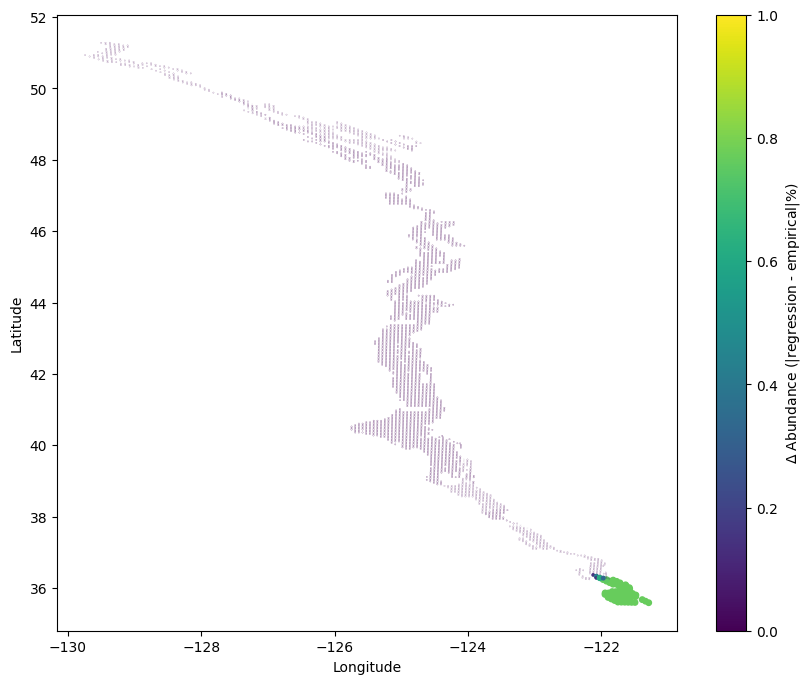

In [209]:
# Reset index to turn longitude/latitude into columns
df_plot = DELTA_ABUNDANCE.reset_index()
pt_size = np.where(
    df_plot["abundance"] > 0, 
    df_plot["abundance"] * 20,
    0.01
)

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    x=df_plot["longitude"], 
    y=df_plot["latitude"], 
    c=df_plot["abundance"], # The color values
    cmap="viridis",
    s=pt_size, # Size of the points,
    vmin = 0,
    vmax = 1.0
)
plt.colorbar(sc, label=r"$\Delta$ Abundance (|regression - empirical|%)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [173]:
(
    kriged_results_regression.groupby(["geostratum_ks"], observed=False)["abundance"].sum() - 
    kriged_results_empirical.groupby(["geostratum_ks"], observed=False)["abundance"].sum()
)

geostratum_ks
1     11110.627161
2         0.000000
3    270622.917271
4      8739.844197
5     12009.297963
6       173.034543
7       327.330636
8       100.923931
Name: abundance, dtype: float64

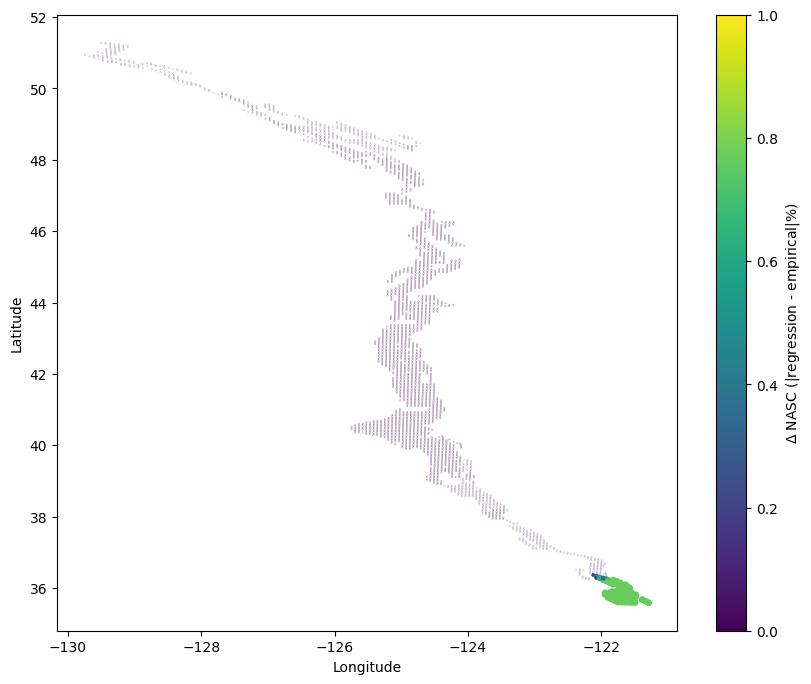

In [212]:
# Reset index to turn longitude/latitude into columns
df_plot = DELTA_NASC.reset_index()
pt_size = np.where(
    df_plot["nasc"] > 0, 
    df_plot["nasc"] * 20,
    0.01
)

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    x=df_plot["longitude"], 
    y=df_plot["latitude"], 
    c=df_plot["nasc"], # The color values
    cmap="viridis",
    s=pt_size, # Size of the points,
    vmin = 0,
    vmax = 1.0
)
plt.colorbar(sc, label=r"$\Delta$ NASC (|regression - empirical|%)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [174]:
(
    kriged_results_regression.groupby(["geostratum_ks"], observed=False)["nasc"].sum() - 
    kriged_results_empirical.groupby(["geostratum_ks"], observed=False)["nasc"].sum()
)

geostratum_ks
1     11.728459
2      0.000000
3    387.780643
4     20.968067
5     44.580475
6      0.536378
7      1.578315
8      0.609454
Name: nasc, dtype: float64

## Apportion kriged estimates

The same comparisons as above can be done to the subequent age-length tables for kriged abundance and biomass.

### Abundance

In [213]:
# ##################################################################################################
# Distribute kriged abundance estimates over length and age/length
# ----------------------------------------------------------------
kriged_abundance_table_empirical = apportionment.distribute_population_estimates(
    data=kriged_results_empirical,
    proportions = dict_ds_number_proportion,
    variable = "abundance",
    group_columns = ["sex", "age_bin", "length_bin", "stratum_ks"],
    data_proportions_link={"geostratum_ks": "stratum_ks"}
)

kriged_abundance_table_regression = apportionment.distribute_population_estimates(
    data=kriged_results_regression,
    proportions = dict_ds_number_proportion,
    variable = "abundance",
    group_columns = ["sex", "age_bin", "length_bin", "stratum_ks"],
    data_proportions_link={"geostratum_ks": "stratum_ks"}
)

# ##################################################################################################
# Standardize the unaged abundance estimates to be distributed over age
# ---------------------------------------------------------------------

kriged_abundance_table_empirical["standardized_unaged"] = apportionment.distribute_unaged_from_aged(
    population_table = kriged_abundance_table_empirical["unaged"],
    reference_table = kriged_abundance_table_empirical["aged"],
    collapse_dims = ["stratum_ks"],
    impute = False
)

kriged_abundance_table_regression["standardized_unaged"] = apportionment.distribute_unaged_from_aged(
    population_table = kriged_abundance_table_regression["unaged"],
    reference_table = kriged_abundance_table_regression["aged"],
    collapse_dims = ["stratum_ks"],
    impute = False
)

# ##################################################################################################
# Consolidate the kriged abundance estimates into a single DataFrame table
# ------------------------------------------------------------------------

overall_kriged_abundance_table_empirical = apportionment.sum_population_tables(
    population_tables={
        "aged": kriged_abundance_table_empirical["aged"],
        "unaged": kriged_abundance_table_empirical["standardized_unaged"]
    },
)

overall_kriged_abundance_table_regression = apportionment.sum_population_tables(
    population_tables={
        "aged": kriged_abundance_table_regression["aged"],
        "unaged": kriged_abundance_table_regression["standardized_unaged"]
    },
)

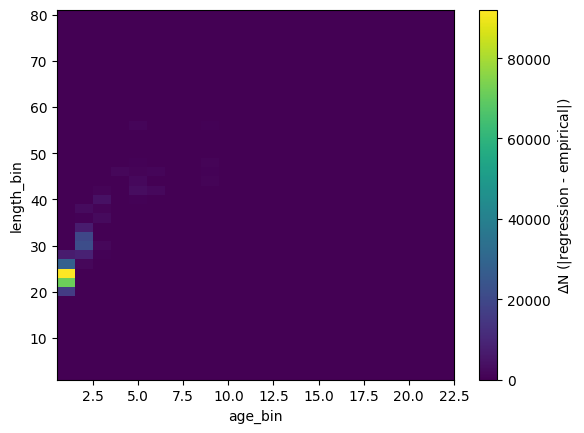

In [214]:
DELTA_KRIGED_ABUNDANCE = np.abs(
    overall_kriged_abundance_table_regression.sum(dim=["sex"]) - 
    overall_kriged_abundance_table_empirical.sum(dim=["sex"])
)

DELTA_KRIGED_ABUNDANCE.plot(
    x="age_bin", 
    y="length_bin", 
    cmap="viridis", 
    cbar_kwargs={"label": r"$\Delta$N (|regression - empirical|)"}
)

In [216]:
overall_kriged_abundance_table_regression.sum() - overall_kriged_abundance_table_empirical.sum()

<xarray.DataArray 'abundance' ()> Size: 8B
array(301684.63197064)

In [220]:
# Percent difference
(
    (
        overall_kriged_abundance_table_regression.sum() - 
        overall_kriged_abundance_table_empirical.sum()
    ) / 
    (
        (
            overall_kriged_abundance_table_regression.sum() +
            overall_kriged_abundance_table_empirical.sum()     
        ) / 2   
    )
) * 1e2

<xarray.DataArray 'abundance' ()> Size: 8B
array(0.01684877)

### Biomass

In [163]:
# ##################################################################################################
# Distribute kriged biomass estimates over length and age/length
# --------------------------------------------------------------

kriged_biomass_table_empirical = apportionment.distribute_population_estimates(
    data=kriged_results_empirical,
    proportions = weight_proportions_empirical,
    variable = "biomass",
    group_columns = ["sex", "age_bin", "length_bin", "stratum_ks"],
    data_proportions_link={"geostratum_ks": "stratum_ks"}
)

kriged_biomass_table_regression = apportionment.distribute_population_estimates(
    data=kriged_results_regression,
    proportions = weight_proportions_regression,
    variable = "biomass",
    group_columns = ["sex", "age_bin", "length_bin", "stratum_ks"],
    data_proportions_link={"geostratum_ks": "stratum_ks"}
)

# ##################################################################################################
# Standardize the unaged biomass estimates to be distributed over age
# ---------------------------------------------------------------------

kriged_biomass_table_empirical["standardized_unaged"] = apportionment.distribute_unaged_from_aged(
    population_table = kriged_biomass_table_empirical["unaged"],
    reference_table = kriged_biomass_table_empirical["aged"],
    collapse_dims = ["stratum_ks"],
    impute = False
)

kriged_biomass_table_regression["standardized_unaged"] = apportionment.distribute_unaged_from_aged(
    population_table = kriged_biomass_table_regression["unaged"],
    reference_table = kriged_biomass_table_regression["aged"],
    collapse_dims = ["stratum_ks"],
    impute = False
)

# ##################################################################################################
# Consolidate the kriged biomass estimates into a single DataFrame table
# ------------------------------------------------------------------------

overall_kriged_biomass_table_empirical = apportionment.sum_population_tables(
    population_tables={
        "aged": kriged_biomass_table_empirical["aged"],
        "unaged": kriged_biomass_table_empirical["standardized_unaged"]
    },
)

overall_kriged_biomass_table_regression = apportionment.sum_population_tables(
    population_tables={
        "aged": kriged_biomass_table_regression["aged"],
        "unaged": kriged_biomass_table_regression["standardized_unaged"]
    },
)

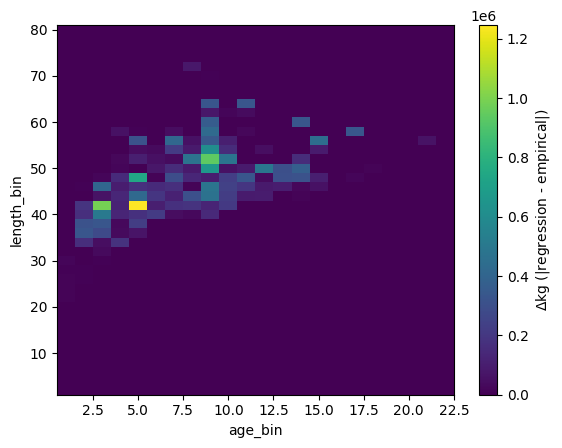

In [165]:
DELTA_KRIGED_BIOMASS = np.abs(
    overall_kriged_biomass_table_regression.sum(dim=["sex"]) - 
    overall_kriged_biomass_table_empirical.sum(dim=["sex"])
)

DELTA_KRIGED_BIOMASS.plot(
    x="age_bin", 
    y="length_bin", 
    cmap="viridis", 
    cbar_kwargs={"label": r"$\Delta$kg (|regression - empirical|)"}
)

In [166]:
overall_kriged_biomass_table_regression.sum() - overall_kriged_biomass_table_empirical.sum()

<xarray.DataArray 'biomass' ()> Size: 8B
array(112799.46937966)

In [219]:
# Percent difference
(
    (
        overall_kriged_biomass_table_regression.sum() - 
        overall_kriged_biomass_table_empirical.sum()
    ) / 
    (
        (
            overall_kriged_biomass_table_regression.sum() +
            overall_kriged_biomass_table_empirical.sum()   
        ) / 2     
    )
) * 1e2

<xarray.DataArray 'biomass' ()> Size: 8B
array(0.00691582)